# Re-creation of Noah Brenowitz's Blog Post

Full blog located here: https://www.noahbrenowitz.com/post/loading_netcdfs/

Noah's github is here: https://github.com/nbren12

All of the original work is from the blog above, minor changes are mine. No warranty implied or given. Reccomend reading the blog post first.

In [1]:
import numpy
import netCDF4 as nc
import xarray
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import shutil
import glob
import plotly.express as px

import matplotlib.pyplot as plt
import pandas as pd


print("Tensorflow:", tf.version.VERSION)
print("Xarray:", xarray.__version__)
print("netCDF4:", nc.__version__)

Tensorflow: 2.9.1
Xarray: 0.20.1
netCDF4: 1.5.7


Note: slightly different versions of the above packages, but worked out of the box for me.  

In [2]:
dir_ = "ncfiles"
kb = 1_024
mb = kb * kb

In [3]:
def save_dirs(target_size: int, total_size: int, dir_: str):
    shutil.rmtree(dir_, ignore_errors=True)
    os.makedirs(dir_)
    nfiles = int(total_size / target_size)
    n = int(target_size / 8)
    ds = xarray.DataArray(numpy.random.uniform(size=(n // 64, 64))).to_dataset(name="a")
    os.makedirs(dir_, exist_ok=True)

    print("Data size (MB):", ds.nbytes/mb)

    for i in range(nfiles):
        path = os.path.join(dir_, "{:2d}.nc".format(i))
        ds.to_netcdf(path)

We have defiend a save directory function.

## Loading netCDF files

Xarray is the 'middle man' for the netCDF files. While xarray does not have a file format (see xkcd another standard comic) netCDF is the reccomended way for xarray dataset I/O. There has been some talk about trying to bypass xarray to go to zarr directly. Here is some of that discussion: https://discourse.pangeo.io/t/netcdf-to-zarr-best-practices/1119/2 . Generally, I think xarray is worth the overhead! 

In [4]:
# from generator method
def load_nc_dir_with_generator(dir_):
    def gen():
        for file in glob.glob(os.path.join(dir_, "*.nc")):
            ds = xarray.open_dataset(file, engine='netcdf4')
            yield {key: tf.convert_to_tensor(val) for key, val in ds.items()}


    sample = next(iter(gen()))

    return tf.data.Dataset.from_generator(
        gen,
        output_signature={
            key: tf.TensorSpec(val.shape, dtype=val.dtype)
            for key, val in sample.items()
        }
    )


def load_nc_dir_with_map_and_xarray(dir_):
    def open_path(path_tensor: tf.Tensor):
        ds = xarray.open_dataset(path_tensor.numpy().decode())
        return tf.convert_to_tensor(ds["a"])
    return tf.data.Dataset.list_files(os.path.join(dir_, "*.nc")).map(
        lambda path: tf.py_function(open_path, [path], Tout=tf.float64),
        )

In [5]:
def load_nc_dir_cached_to_tfrecord(dir_):
    """Save data to tfRecord, open it, and deserialize
    
    Note that tfrecords are not that complicated! The simply store some
    bytes, and you can serialize data into those bytes however you find
    convenient. In this case, I serialie with `tf.io.serialize_tensor` and 
    deserialize with `tf.io.parse_tensor`. No need for `tf.train.Example` or any
    of the other complexities mentioned in the official tutorial.

    """
    generator_tfds = load_nc_dir_with_generator(dir_)
    writer = tf.data.experimental.TFRecordWriter("local.tfrecord")
    writer.write(generator_tfds.map(lambda x: tf.io.serialize_tensor(x["a"])))

    return tf.data.TFRecordDataset("local.tfrecord").map(
        lambda x: tf.io.parse_tensor(x, tf.float64))


def load_nc_dir_after_save(dir_):
    generator_tfds = load_nc_dir_with_generator(dir_)
    tf.data.experimental.save(generator_tfds, "local_ds")
    return tf.data.experimental.load("local_ds")


In [6]:
def load_nc_dir_cache_to_disk(dir_):
    generator_tfds = load_nc_dir_with_generator(dir_)
    cached = generator_tfds.cache(f"{dir_}/.cache")
    list(cached)
    return cached
    

def load_nc_dir_cache_to_mem(dir_):
    generator_tfds = load_nc_dir_with_generator(dir_)
    cached = generator_tfds.cache()
    list(cached)
    return cached

In [7]:
def load_nc_dir_to_bytes(dir_):
    return tf.data.Dataset.list_files(os.path.join(dir_, "*.nc")).map(tf.io.read_file)    

In [8]:
def get_datasets(dir_):
    return dict(
        generator = load_nc_dir_with_generator(dir_),
        map = load_nc_dir_with_map_and_xarray(dir_),
        tfrecord = load_nc_dir_cached_to_tfrecord(dir_),
        tf_data_save = load_nc_dir_after_save(dir_),
        cache_disk = load_nc_dir_cache_to_disk(dir_),
        bytes_only = load_nc_dir_to_bytes(dir_),
        cache_mem = load_nc_dir_cache_to_mem(dir_),
    )

In [9]:
import timeit

total_size = 128 * mb

def show_timings(dir_):
    datasets = get_datasets(dir_)
    return {
        key: timeit.timeit(lambda: list(datasets[key]), number=2) 
        for key in datasets
    }

kb_range = [256, 1024, 4000, 8000, 16000, 32000]

for kb in kb_range:
    save_dirs(kb * 1024, total_size, f"{dir_}/{kb}")

timings = {}


for kb in kb_range:
    print(f"Working on {kb}")
    timings[kb] = show_timings(f"{dir_}/{kb}")

Data size (MB): 0.25
Data size (MB): 1.0
Data size (MB): 3.90625
Data size (MB): 7.8125
Data size (MB): 15.625
Data size (MB): 31.25
Working on 256
Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


2022-08-16 12:56:25.250383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 12:56:28.742574: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Working on 1024


2022-08-16 12:56:36.123322: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Working on 4000


2022-08-16 12:56:39.841625: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Working on 8000


2022-08-16 12:56:42.386619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Working on 16000


2022-08-16 12:56:44.744943: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Working on 32000


2022-08-16 12:56:46.898965: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
timings


{256: {'generator': 1.9742570879999946,
  'map': 1.9524569020000015,
  'tfrecord': 0.12045287499999802,
  'tf_data_save': 0.1997525260000046,
  'cache_disk': 0.235426271999998,
  'bytes_only': 0.12361202200000321,
  'cache_mem': 0.08752585500000265},
 1024: {'generator': 0.6297760269999984,
  'map': 0.5865983759999978,
  'tfrecord': 0.1240392740000047,
  'tf_data_save': 0.1833259790000028,
  'cache_disk': 0.20366954099999646,
  'bytes_only': 0.2117646190000002,
  'cache_mem': 0.029911891000004687},
 4000: {'generator': 0.2542604110000042,
  'map': 0.22997436699999696,
  'tfrecord': 0.1397990990000011,
  'tf_data_save': 0.1834590349999985,
  'cache_disk': 0.12304614299999628,
  'bytes_only': 0.09292961899999597,
  'cache_mem': 0.011606730000004006},
 8000: {'generator': 0.18456372200000004,
  'map': 0.1651248289999998,
  'tfrecord': 0.15584218099999703,
  'tf_data_save': 0.2278701990000016,
  'cache_disk': 0.11570968400000226,
  'bytes_only': 0.09102943599999946,
  'cache_mem': 0.006335

This plot looks very different than Noah's (exact opposite?), some user error going on.

In [11]:
df = pd.DataFrame.from_dict(timings)
df

,256,1024,4000,8000,16000,32000
generator,1.974257,0.629776,0.254260,0.184564,0.139769,0.114706
map,1.952457,0.586598,0.229974,0.165125,0.119431,0.101533
tfrecord,0.120453,0.124039,0.139799,0.155842,0.149475,0.171001
tf_data_save,0.199753,0.183326,0.183459,0.227870,0.220712,0.248157
cache_disk,0.235426,0.203670,0.123046,0.115710,0.103177,0.101323
bytes_only,0.123612,0.211765,0.092930,0.091029,0.092644,0.086319
cache_mem,0.087526,0.029912,0.011607,0.006335,0.009106,0.003690


<AxesSubplot:>

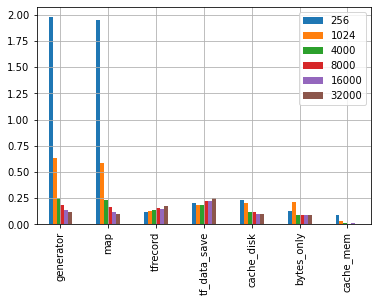

In [12]:
df.plot.bar(grid=True)

In [13]:
read_ds = load_nc_dir_to_bytes("ncfiles/256")
item = next(iter(read_ds))

def open_bytes(bytes_tensor: tf.Tensor):
    nc_bytes = bytes_tensor.numpy()
    # syntax from https://unidata.github.io/netcdf4-python/
    d = nc.Dataset('dummy.nc', memory=nc_bytes)
    return tf.convert_to_tensor(d["a"][:])

%timeit  open_bytes(item)

1.13 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
# is tensorflow io tensor serialization faster?
ds = open_bytes(item)
bytes_tensor = tf.io.serialize_tensor(tf.convert_to_tensor(ds))
%timeit tf.io.parse_tensor(bytes_tensor, tf.float64)

39.7 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
